In [301]:
import networkx as nx
from numpy  import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.stats import pareto, lognorm
import matplotlib.colors as mcolors
import pandas as pd

n = 30


# Set plot style
sns.set(style='whitegrid')


In [302]:
def analyze_network(G, name):
    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees)
    clustering_coeffs = nx.clustering(G).values()
    avg_clustering = np.mean(list(clustering_coeffs))
    shortest_path_length = dict(nx.shortest_path_length(G))
    avg_path_length = np.mean([l for target_dict in shortest_path_length.values() for l in target_dict.values()])

    print(f"Analysis of {name}:")
    print(f"- Number of nodes: {G.number_of_nodes()}")
    print(f"- Number of edges: {G.number_of_edges()}")
    print(f"- Average degree: {avg_degree:.2f}")
    print(f"- Average clustering coefficient: {avg_clustering:.4f}")
    print(f"- Average shortest path length: {avg_path_length:.2f}")

    # Degree distribution plot
    plt.figure(figsize=(8, 6))
    sns.histplot(degrees, bins=range(max(degrees)+1), kde=False)
    plt.title(f'Degree Distribution of {name}')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()


### Let's generate different samples of complex networks to test our model and see how each of them behave


## 1- Barabasi-Albert model (Scale-free Networks)
Few nodes have high degree (many connections), while most nodes have few connections. Uses preferential attachment, meaning that new nodes have higher probability of attaching to existing nodes with higher degree. 
- Power law degree distribution: small number of highly connected hubs
- Heterogeneous structure: nodes with a vastly different number of connections
- Robustness: resistant to random failures but vulnerable to attacks on central nodes -> this is what we are gonna analyze here.

### Parameters:
1) n: the number of nodes
2) the number of edges a new node will create when added to the network. These edges are preferrably attached to existing nodes based on their current degree.

As an example, this one could be suitable to model the growth of social networks where a few people have many connections.

In [303]:
m = 4  # Number of edges to attach from a new node to existing nodes

barabasi_graph = nx.barabasi_albert_graph(n, m)
barabasi_graph = barabasi_graph.to_directed()

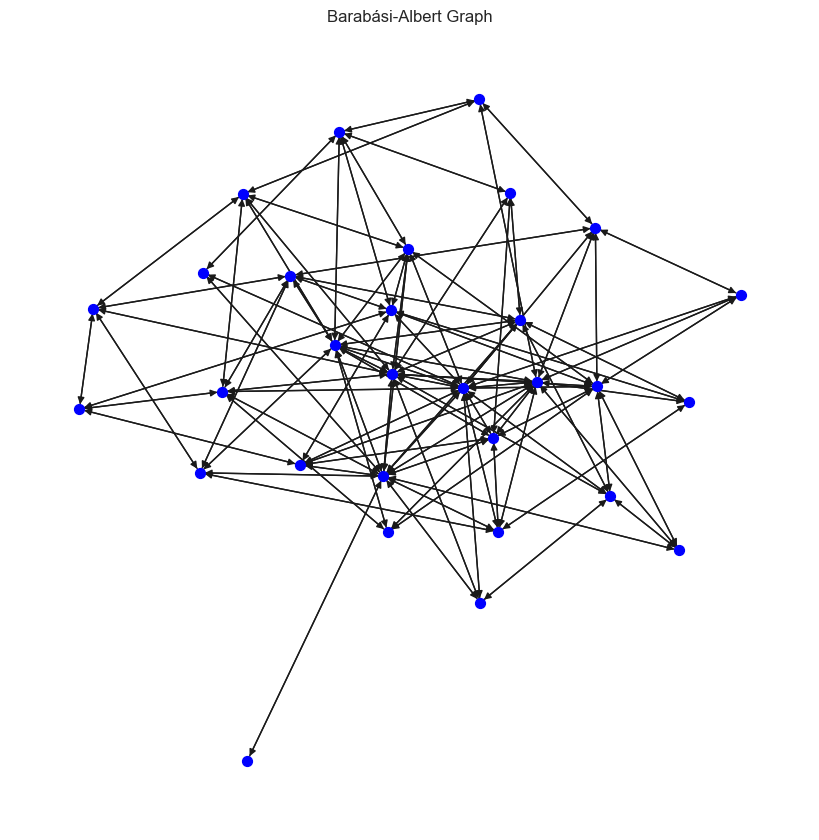

In [306]:
plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
nx.draw(barabasi_graph, node_size=50, node_color="blue", with_labels=False)
plt.title("Barabási-Albert Graph")
plt.show()

Analysis of Barabási-albert model:
- Number of nodes: 30
- Number of edges: 208
- Average degree: 13.87
- Average clustering coefficient: 0.3303
- Average shortest path length: 1.84


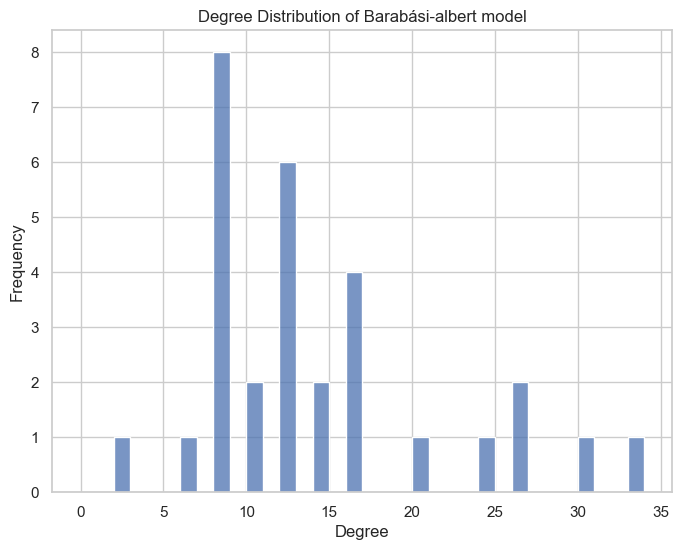

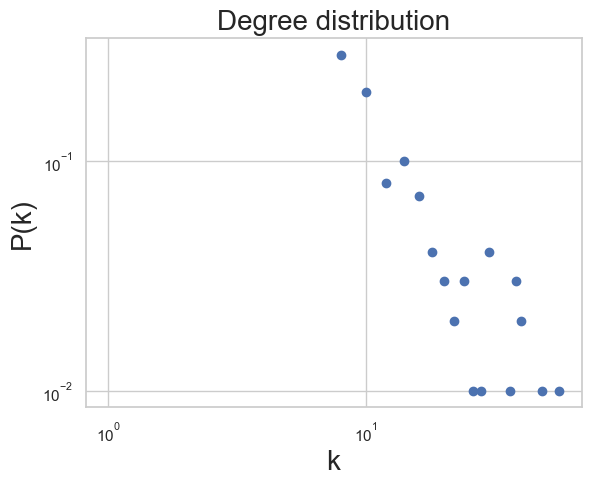

In [307]:
analyze_network(barabasi_graph, 'Barabási-albert model')

def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

ks, Pk = degree_distribution(G)

plt.figure()
plt.loglog(ks,Pk,'bo',base=10)
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
plt.grid(True)
plt.savefig('degree_dist.eps') #save the figure into a file
plt.show(True)


In [267]:
M = np.column_stack((ks,Pk))
np.savetxt('BA_distribution.txt', M, delimiter='\t')

## Small World Network
- Local clustering. Nodes tend to be connected to their neighbors. 
- Short average path lenght: There is a few of "hops" or connections betwen two nodes in the graph. The p parameter defines the probability of rewire.

### Parameters:
1) Number of Nodes (n): total number of nodes/vertices. This might represent people, computers, neurons etc.
2) Nearest neighbors (k): each node is connected to k nearest neighbors. If 𝑘 = 2, each node connects to its two immediate neighbors on both sides (like a circular lattice). Controls the local clustering of the network.
3) Rewiring probability (p): controls the degree of randomness in the network. For each edge in the initial lattice, it is randomly rewired with probability p.
- When p=0, the network is a regular lattice with high clustering and long path lengths.
- When p=1, the network is fully random, with low clustering but short path lengths.
- When 0<p<1, the network becomes a Small-World, where you retain some clustering while reducing the path length.


In [308]:
# Parameters
k = 4   # each node is connected to k nearest neighbors in ring topology
p = 0.4  # probability of rewiring each edge

# Create an undirected Small-World network
G_undirected = nx.watts_strogatz_graph(n, k, p)

# Convert it to a directed graph by creating directed edges from the undirected graph
G_directed = nx.DiGraph()
G_directed.add_edges_from((u, v) for u, v in G_undirected.edges())
G_directed.add_edges_from((v, u) for u, v in G_undirected.edges())
SW_graph = G_directed

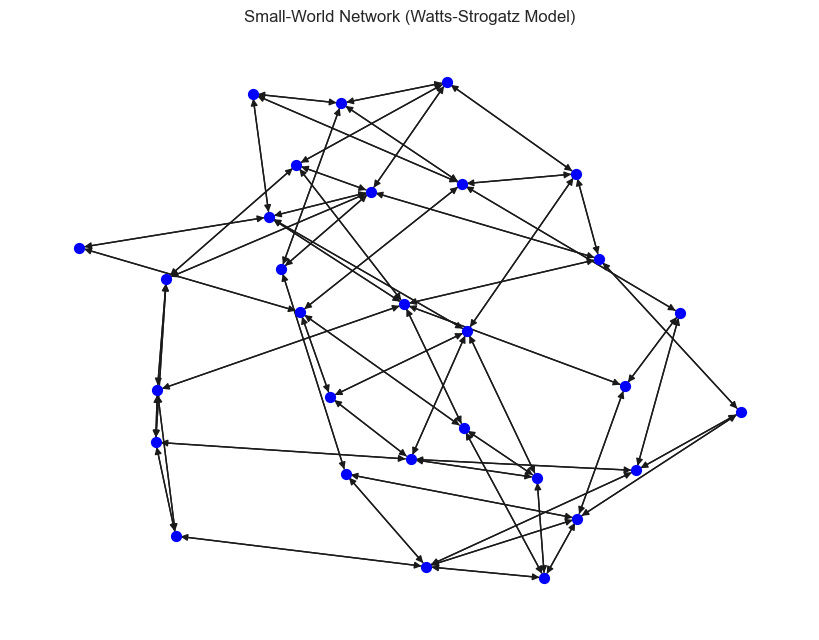

In [309]:

# Draw the network
plt.figure(figsize=(8, 6))
nx.draw(G_directed, node_size=50, node_color='blue', with_labels=False)
plt.title("Small-World Network (Watts-Strogatz Model)")
plt.show()

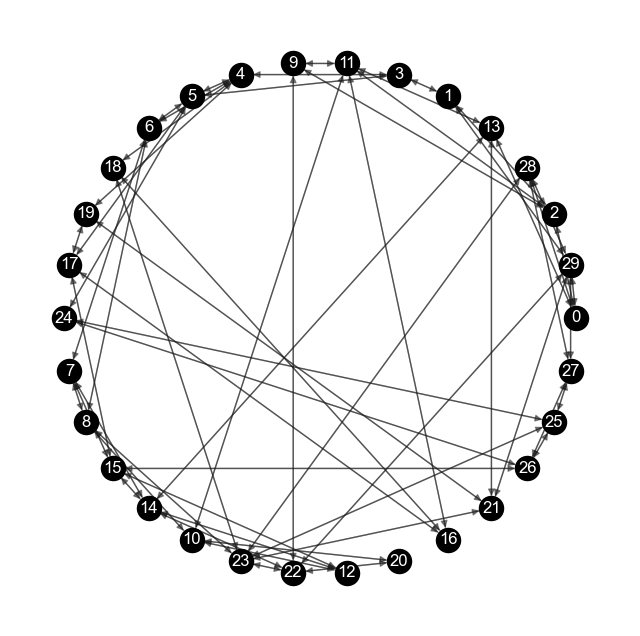

In [310]:
pos = nx.circular_layout(SW_graph)
plt.figure(figsize=(8,8))
plt.axis("off")
nx.draw_networkx_nodes(SW_graph, pos, node_size=300, node_color="black")
nx.draw_networkx_edges(SW_graph, pos, alpha=0.500)
nx.draw_networkx_labels(SW_graph, pos, font_color="white")
plt.show()

Analysis of Small-world Network:
- Number of nodes: 30
- Number of edges: 120
- Average degree: 8.00
- Average clustering coefficient: 0.1622
- Average shortest path length: 2.43


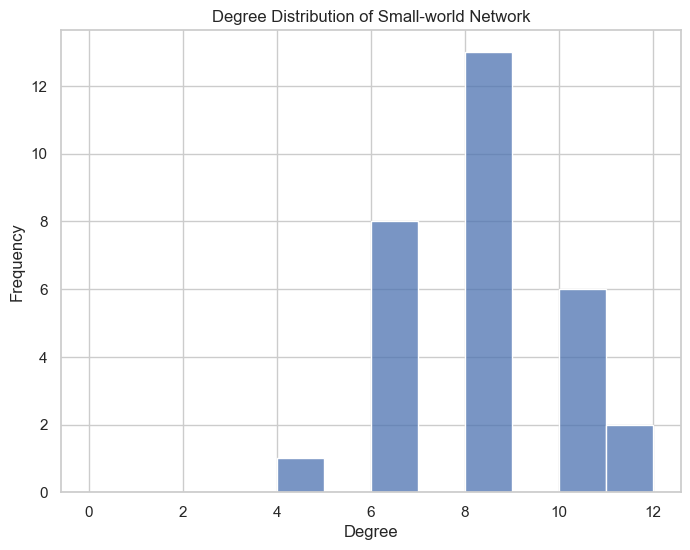

In [311]:
analyze_network(SW_graph, 'Small-world Network')

## Random Graph Network - Erdős–Rényi (ER) model

- This graph is composed by N nodes and each connection between pairs of nodes are stablished according to probability p. This is a typical case of a Bernoulli process.




In [314]:

p = 0.1  # Probability of edge creation between any two nodes
ER_graph = nx.gnp_random_graph(n, p, seed=None, directed=True)


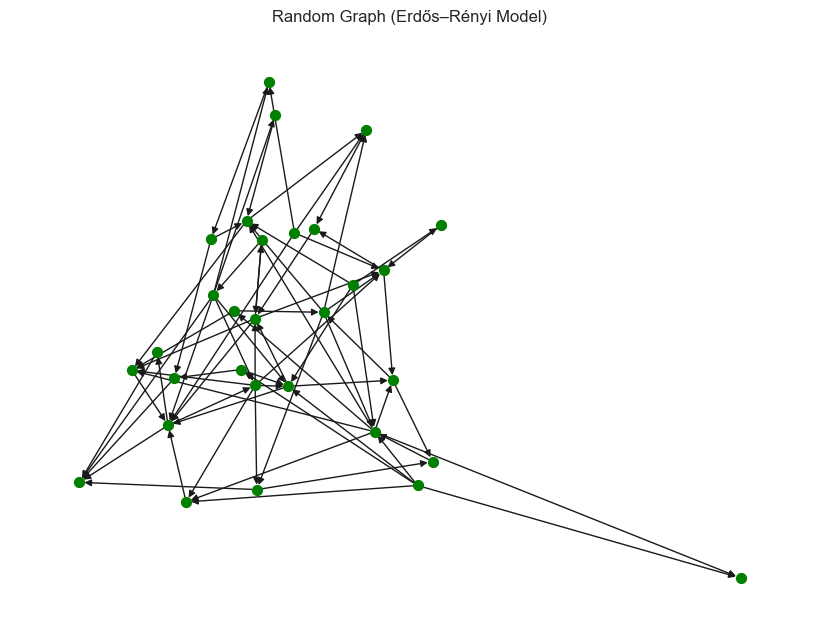

In [315]:

# Draw the network
plt.figure(figsize=(8, 6))
nx.draw(ER_graph, node_size=50, node_color='green', with_labels=False)
plt.title("Random Graph (Erdős–Rényi Model)")
plt.show()


In [316]:
def degree_distribution(GER):
    vk = dict(GER.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

In [317]:
ks, Pk = degree_distribution(ER_graph)

Analysis of Random Graph:
- Number of nodes: 30
- Number of edges: 72
- Average degree: 4.80
- Average clustering coefficient: 0.1250
- Average shortest path length: 3.55


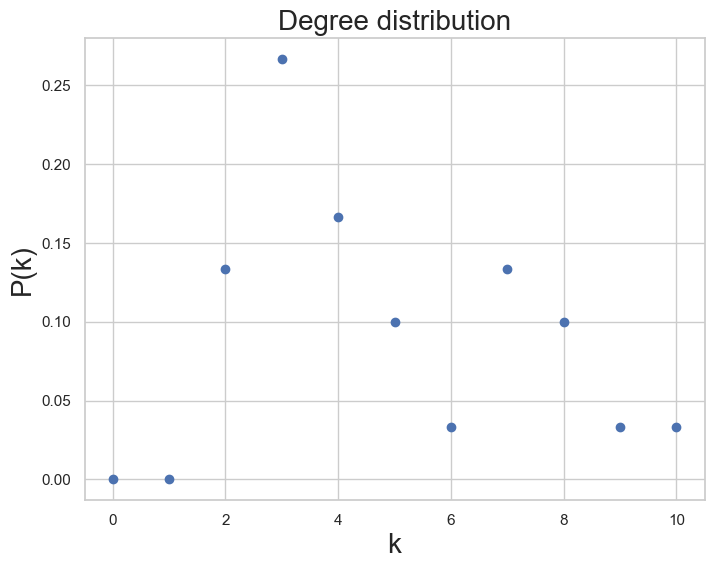

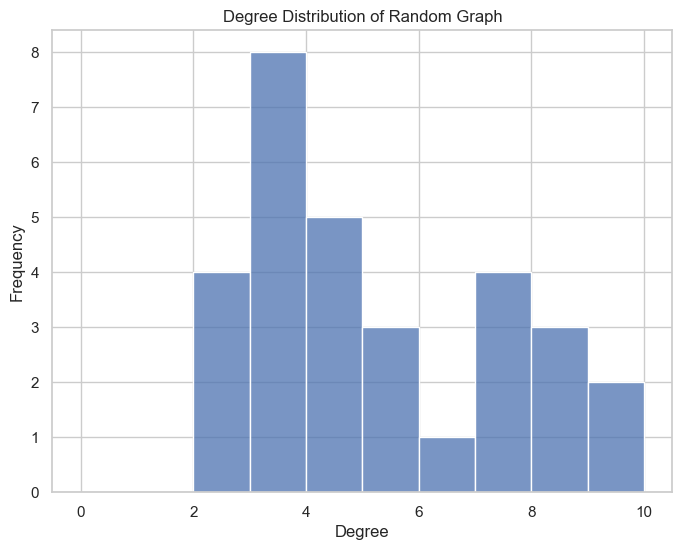

In [318]:
plt.figure(figsize=(8,6))
plt.plot(ks,Pk,'bo', label='Data')
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
plt.grid(True)
#plt.savefig('degree_dist.eps') #save the figure into a file


analyze_network(ER_graph, 'Random Graph')

## Modelo de Waxman
- n: O número de nós no grafo. Cada nó representa uma entidade conectada na rede.
- alpha: Controla a densidade de arestas no grafo. Valores maiores de alpha aumentam a probabilidade de haver uma aresta entre nós, independentemente da distância.
- beta: Controla como a distância influencia a probabilidade de haver uma aresta entre nós. Valores maiores de beta tornam as conexões mais prováveis, mesmo a longas distâncias. Valores menores fazem com que a probabilidade decaia mais rapidamente com a distância.

- Baseada em distâncias: A conectividade depende da proximidade dos nós no espaço.
- Controle de densidade e alcance: Os parâmetros a e b permitem controlar a densidade geral da rede e a probabilidade de conexões entre nós distantes.
- Modelo probabilístico: O modelo Waxman é estocástico, o que significa que a estrutura da rede mudará a cada execução, mesmo com os mesmos parâmetros.


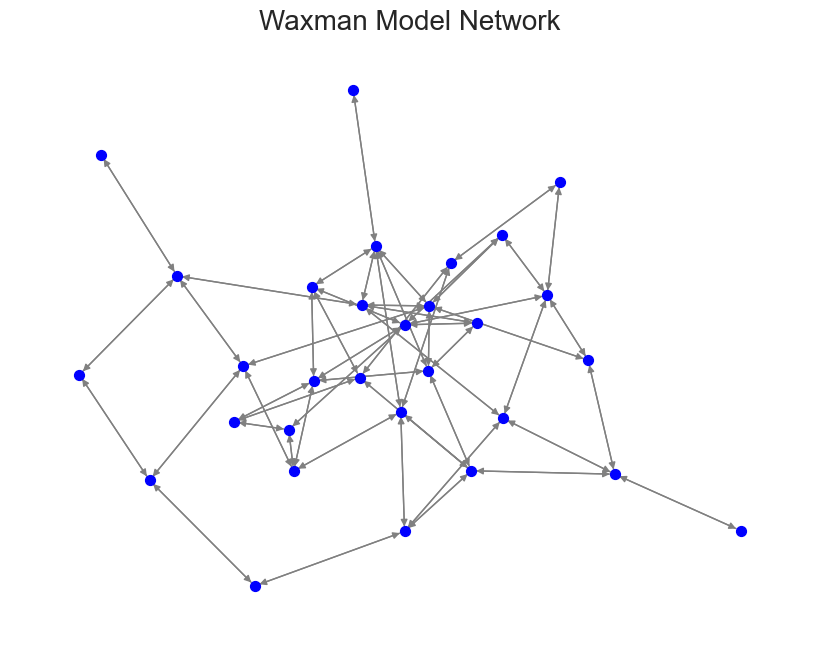

In [326]:


# Parâmetros para o modelo de Waxman
alpha = 0.4  # Parâmetro que controla a densidade de arestas
beta = 0.3   # Parâmetro que controla a decaída da probabilidade com a distância

G_undirected = nx.waxman_graph(n, alpha=alpha, beta=beta, domain=(0, 0, 1, 1))

# Convert to a directed graph
G_directed = nx.DiGraph()
G_directed.add_edges_from((u, v) for u, v in G_undirected.edges())
G_directed.add_edges_from((v, u) for u, v in G_undirected.edges())
WM_graph = G_directed

# Desenhar a rede
plt.figure(figsize=(8, 6))
nx.draw(WM_graph, node_size=50, node_color='blue', with_labels=False, edge_color='gray')
plt.title("Waxman Model Network",fontsize=20)
plt.show()

Analysis of Small-world Network:
- Number of nodes: 30
- Number of edges: 110
- Average degree: 7.33
- Average clustering coefficient: 0.0556
- Average shortest path length: 2.59


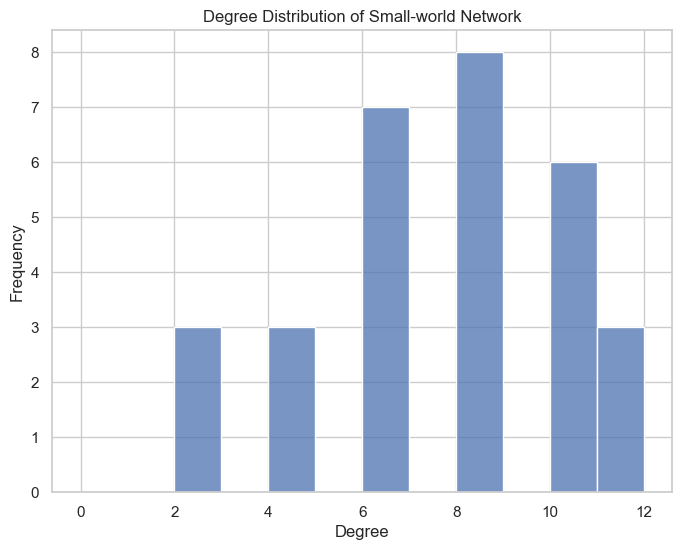

In [327]:
analyze_network(WM_graph, 'Small-world Network')

## Assigning values for nodes and edges

We will assign values for the nodes and the edges of the graphs, using uniform and exponential distributions, both with average $\mu$.
### Constraints:
Edge constraint: $A_{ij}$ ≤ Equity(j)


Node Constraint: The total investments made by node $i$ ($A_{ij}$) cannot exceed its own equity

In [328]:
def assign_node_equity(G, mean_equity, distribution='uniform'):
    n = G.number_of_nodes()
    if distribution == 'uniform':
        equity_values = np.random.uniform(0, 2 * mean_equity, n)
    elif distribution == 'exponential':
        equity_values = np.random.exponential(mean_equity, n)
    else:
        raise ValueError("Unsupported distribution type.")
    equity_dict = {node: equity for node, equity in zip(G.nodes(), equity_values)}
    nx.set_node_attributes(G, equity_dict, 'equity')
    return G


# Function to assign investments to edges
def assign_edge_investments(G, mean_investment, distribution='uniform'):
    for node in G.nodes():
        equity_i = G.nodes[node]['equity']
        out_edges = list(G.out_edges(node))
        num_out_edges = len(out_edges)
        if num_out_edges == 0:
            continue
        # Generate potential investments for each outgoing edge
        if distribution == 'uniform':
            investments = np.random.uniform(0, 2 * mean_investment, num_out_edges)
        elif distribution == 'exponential':
            investments = np.random.exponential(mean_investment, num_out_edges)
        else:
            raise ValueError("Unsupported distribution type.")
        # Ensure that investments do not exceed the equity of node j
        adjusted_investments = []
        for idx, (u, v) in enumerate(out_edges):
            equity_j = G.nodes[v]['equity']
            investment = investments[idx]
            # Cap investment at Equity_j
            investment = min(investment, equity_j)
            adjusted_investments.append(investment)
        # Calculate total potential investment
        total_investment = sum(adjusted_investments)
        # If total investment exceeds Equity_i, scale down the investments
        if total_investment > equity_i:
            scaling_factor = equity_i / total_investment
            adjusted_investments = [inv * scaling_factor for inv in adjusted_investments]
        # Assign investments to edges
        for idx, (u, v) in enumerate(out_edges):
            G.edges[u, v]['investment'] = adjusted_investments[idx]
    return G

# Function to calculate the relative economic value of node j in comparison to the entire network
def calculate_relative_values(G):
    # Calculate total investments made by all nodes
    total_network_investment = sum([G.edges[u, v]['investment'] for u, v in G.edges()])
    # Calculate investments made by each node
    node_investments = {}
    for node in G.nodes():
        out_edges = list(G.out_edges(node))
        total_investment = sum([G.edges[u, v]['investment'] for u, v in out_edges])
        node_investments[node] = total_investment
    # Calculate v_j for each node
    node_values = {}
    for node in G.nodes():
        A_j = node_investments.get(node, 0)
        v_j = A_j / total_network_investment if total_network_investment > 0 else 0
        node_values[node] = v_j
        # Optionally, store v_j as a node attribute
        G.nodes[node]['v_j'] = v_j
    return G


In [329]:
mu_equity = 10000
mu_investment = 50
distribution = 'uniform'

graphs = {}

ER_graph_complete = assign_node_equity(ER_graph, mean_equity=mu_equity, distribution=distribution)
SW_graph_complete = assign_node_equity(SW_graph, mean_equity=mu_equity, distribution=distribution)
WM_graph_complete = assign_node_equity(WM_graph, mean_equity=mu_equity, distribution=distribution)
BA_graph_complete = assign_node_equity(barabasi_graph, mean_equity=mu_equity, distribution=distribution)

ER_graph_complete = assign_edge_investments(ER_graph, mean_investment=mu_investment, distribution=distribution)
SW_graph_complete = assign_edge_investments(SW_graph, mean_investment=mu_investment, distribution=distribution)
WM_graph_complete = assign_edge_investments(WM_graph, mean_investment=mu_investment, distribution=distribution)
BA_graph_complete = assign_edge_investments(barabasi_graph, mean_investment=mu_investment, distribution=distribution)

ER_graph_complete = calculate_relative_values(ER_graph)
SW_graph_complete = calculate_relative_values(SW_graph)
WM_graph_complete = calculate_relative_values(WM_graph)
BA_graph_complete = calculate_relative_values(barabasi_graph)

graphs['erdos_renyi'] = ER_graph_complete
graphs['barabasi_albert'] = BA_graph_complete
graphs['small_world'] = SW_graph_complete
graphs['waxman'] = WM_graph_complete


In [330]:
def create_adjacency_matrix(G):
    """
    Creates an adjacency matrix representing the investments between nodes.

    Parameters:
    - G: NetworkX graph object.

    Returns:
    - adjacency_matrix: pandas DataFrame representing the adjacency matrix.
    """
    nodes = sorted(G.nodes())
    adjacency_matrix = pd.DataFrame(0.0, index=nodes, columns=nodes)
    for u, v in G.edges():
        investment = G.edges[u, v].get('investment', 0.0)
        adjacency_matrix.loc[u, v] = investment
    return adjacency_matrix


def create_node_table(G):
    """
    Creates a table with columns ['node', 'equity', 'total_investments', 'v_j'] for each node.

    Parameters:
    - G: NetworkX graph object.

    Returns:
    - node_table: pandas DataFrame containing the node data.
    """
    node_data = []
    for node in G.nodes():
        equity = G.nodes[node]['equity']
        total_investments = sum([G.edges[u, v]['investment'] for u, v in G.out_edges(node)])
        v_j = G.nodes[node]['v_j']
        node_data.append({
            'node': node,
            'equity': equity,
            'total_investments': total_investments,
            'v_j': v_j
        })
    node_table = pd.DataFrame(node_data)
    return node_table



In [333]:
# Generate adjacency matrix for Erdős–Rényi Graph
adj_matrix_er = create_adjacency_matrix(graphs['erdos_renyi'])
print("Adjacency Matrix for Directed Erdős–Rényi Graph:")

# Generate node data table for Erdős–Rényi Graph
node_table_er = create_node_table(graphs['erdos_renyi'])
#print("\nNode Data Table for Directed Erdős–Rényi Graph:")
#node_table_er
adj_matrix_er.to_excel("adj_matrix.xlsx")



Adjacency Matrix for Directed Erdős–Rényi Graph:


In [248]:
# Verify constraints for a specific node, e.g., node 0
node = 0
equity_i = graphs['erdos_renyi'].nodes[node]['equity']
out_edges = list(graphs['erdos_renyi'].out_edges(node))
total_investment = sum([graphs['erdos_renyi'].edges[u, v]['investment'] for u, v in out_edges])
print(f"Equity of node {node}: {equity_i}")
print(f"Total investments made by node {node}: {total_investment}")
print(f"Constraint satisfied: {total_investment <= equity_i}")

# Verify that no investment exceeds the equity of node j
violations = []
for u, v in graphs['erdos_renyi'].edges():
    investment = graphs['erdos_renyi'].edges[u, v]['investment']
    equity_j = graphs['erdos_renyi'].nodes[v]['equity']
    if investment > equity_j:
        violations.append((u, v))
if violations:
    print("Violations found where investment exceeds recipient's equity:", violations)
else:
    print("All investments are within the recipient's equity constraints.")


Equity of node 0: 16263.233332738459
Total investments made by node 0: 325.404756081677
Constraint satisfied: True
All investments are within the recipient's equity constraints.


In [57]:
# We will shock the node with the githest degree in the network
def get_highest_degree_node(G):
    degree_dict = dict(G.degree())
    return max(degree_dict, key=degree_dict.get)

In [58]:
for name, G in graphs.items():
    E = nx.get_node_attributes(G, 'E') 

print(sum(list(E.values())))
    

766.4871581953433


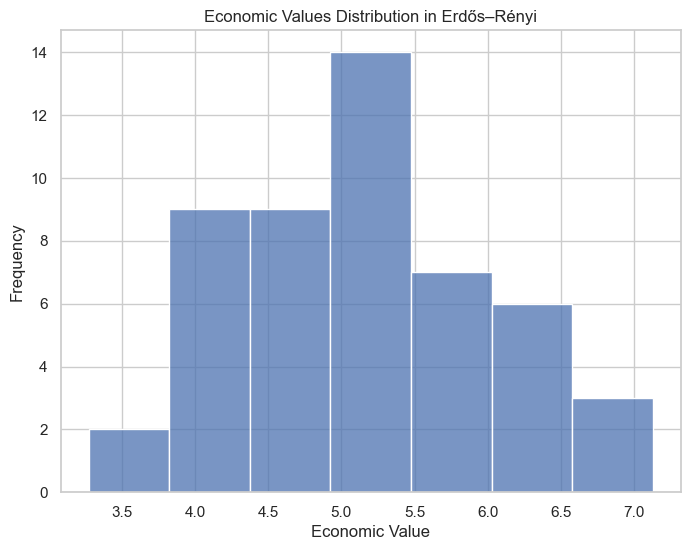

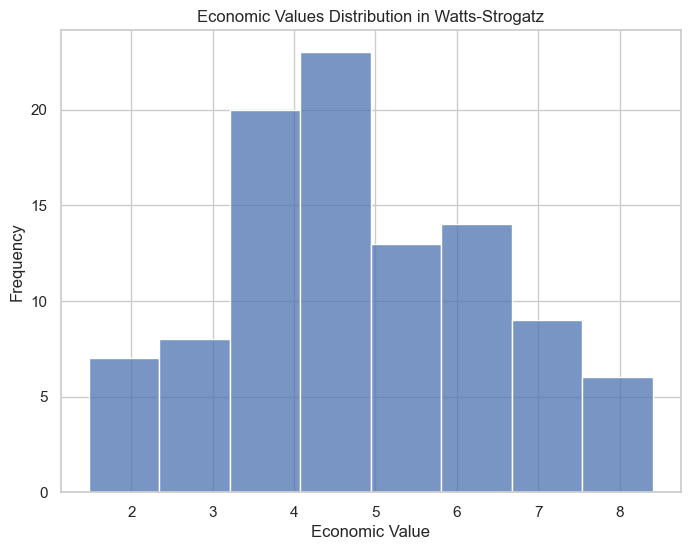

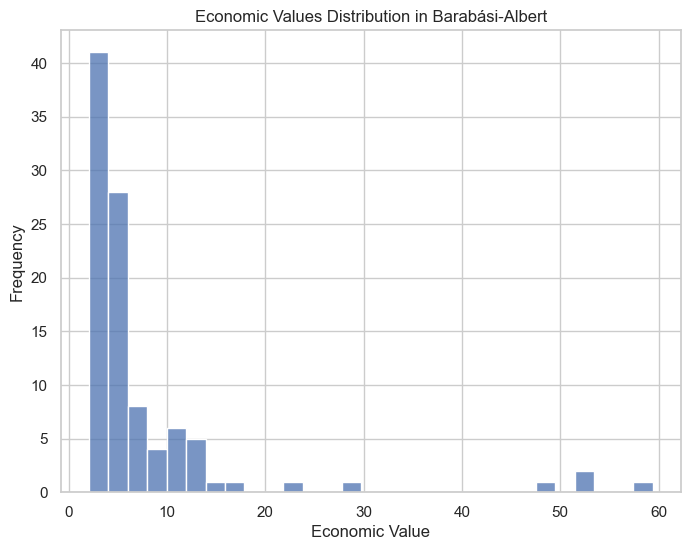

In [60]:

for name, G in graphs.items():
    E_values = list(nx.get_node_attributes(G, 'E').values())
    plt.figure(figsize=(8, 6))
    sns.histplot(E_values, kde=False)
    plt.title(f'Economic Values Distribution in {name}')
    plt.xlabel('Economic Value')
    plt.ylabel('Frequency')
    plt.show()


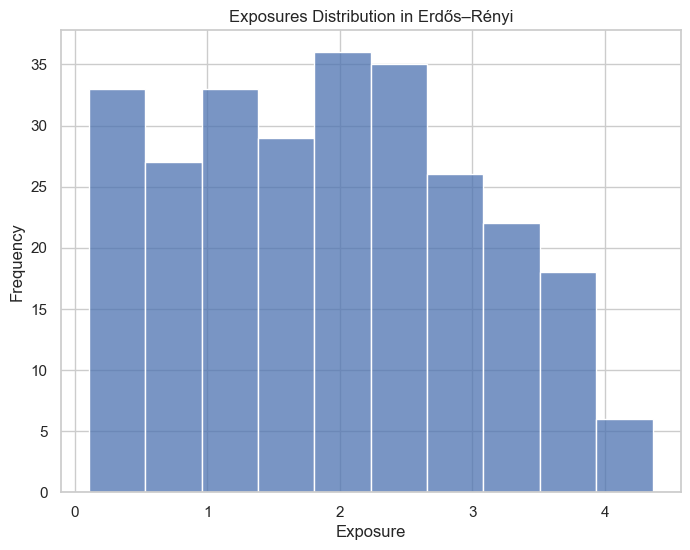

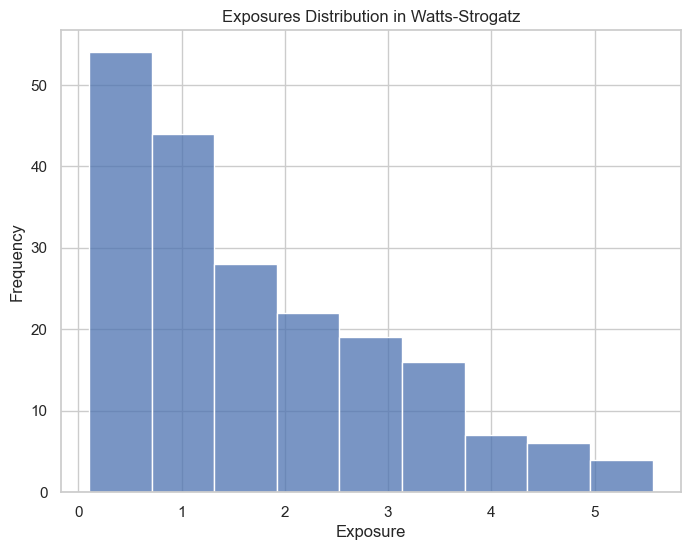

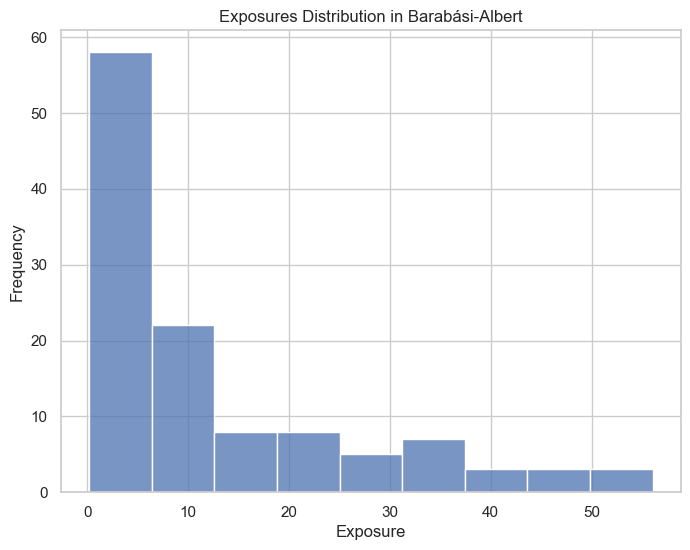

In [61]:

for name, G in graphs.items():
    exposures = [data['weight'] for u, v, data in G.edges(data=True)]
    plt.figure(figsize=(8, 6))
    sns.histplot(exposures, kde=False)
    plt.title(f'Exposures Distribution in {name}')
    plt.xlabel('Exposure')
    plt.ylabel('Frequency')
    plt.show()


## Visualizing central nodes
Graphs have centrality measures that help identify the most important nodes in a network based on various criteria. 

In [ ]:
def debtrank(G, initial_shock_nodes, max_iter=10):
    # Initialize distress levels
    h = {node: 0 for node in G.nodes()}
    for node in initial_shock_nodes:
        h[node] = 1.0  # Full distress for shocked nodes

    # Initialize state: active (A), inactive (I), or inactive but distressed (D)
    state = {node: 'A' if h[node] > 0 else 'I' for node in G.nodes()}
    s = 0  # Iteration counter

    E = nx.get_node_attributes(G, 'E')  # Should be a dictionary {node: economic_value}
    if not E:
        raise ValueError("Economic values (attribute 'E') are missing from the graph nodes.")
    L = {}  

    # Precompute L_ij for all edges
    for i, j in G.edges():
        if E.get(i, 0) > 0:
            L_ij = G[i][j]['weight'] / E[i]
            L[(i, j)] = L_ij
        else:
            L[(i, j)] = 0

    h_over_time = [h.copy()]  # Record distress levels over time

    while 'A' in state.values() and s < max_iter:
        new_h = h.copy()
        for i in G.nodes():
            if state[i] == 'A':
                for j in G.successors(i):
                    delta_h = (1 - h[j]) * L.get((i, j), 0) * h[i]
                    if delta_h > 0:
                        new_h[j] += delta_h
                        if state[j] != 'D':
                            state[j] = 'A'
                state[i] = 'D'  # Node i has propagated its distress
        # Check for convergence
        if new_h == h:
            break
        h = new_h
        h_over_time.append(h.copy())
        s += 1

    # Calculate DebtRank
    E_total = sum(list(E.values()))
    if E_total == 0:
        raise ValueError("Total economic value is zero, cannot compute DebtRank.")
    numerator = sum([E[i] * (h[i] - (1.0 if i in initial_shock_nodes else 0.0)) for i in G.nodes()])
    R = numerator / E_total
    return h, R, h_over_time


In [ ]:
results = {}

for name, G in graphs.items():
    initial_shock_node = get_highest_degree_node(G)
    print(f"Running DebtRank on {name} with initial shock node {initial_shock_node}")
    try:
        distress_levels, debt_rank, h_over_time = debtrank(G, [initial_shock_node])
        results[name] = {
            'distress_levels': distress_levels,
            'debt_rank': debt_rank,
            'h_over_time': h_over_time,
            'initial_shock_node': initial_shock_node
        }
        print(f"DebtRank for {name}: {debt_rank:.4f}")
    except Exception as e:
        print(f"An error occurred while running DebtRank on {name}: {e}")


In [63]:
def prepare_visualization_data(G):
    # Compute centrality measures
    centrality = compute_centrality_measures(G)
    
    # Get economic values
    E = nx.get_node_attributes(G, 'E')
    
    return centrality, E

def get_node_sizes_and_colors(G, centrality, E, centrality_measure='betweenness'):
    # Normalize economic values for node sizes
    max_economic_value = max(E.values())
    node_sizes = [500 * (E[node] / max_economic_value) for node in G.nodes()]
    
    # Get centrality values for node colors
    centrality_values = centrality[centrality_measure]
    centrality_colors = [centrality_values[node] for node in G.nodes()]
    
    return node_sizes, centrality_colors


def visualize_graph(G, positions, node_sizes, node_colors, title, edge_weights=None):
    plt.figure(figsize=(12, 8))
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G,
        positions,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        alpha=0.9
    )
    
    # Draw edges
    if edge_weights:
        # Normalize edge weights for width
        max_weight = max(edge_weights.values())
        edge_widths = [edge_weights[(u, v)] / max_weight * 2 for u, v in G.edges()]
        nx.draw_networkx_edges(
            G,
            positions,
            width=edge_widths,
            alpha=0.5,
            arrows=True,
            arrowstyle='-|>',
            arrowsize=10
        )
    else:
        nx.draw_networkx_edges(
            G,
            positions,
            alpha=0.5,
            arrows=True,
            arrowstyle='-|>',
            arrowsize=10
        )
    
    # Add colorbar for node colors
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm._A = []
    plt.colorbar(sm, label='Centrality')
    
    plt.title(title)
    plt.axis('off')
    plt.show()



/var/folders/xx/w1_zq0mx265cfc9y7_64zcz80000gn/T/ipykernel_4960/3477806779.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Centrality')


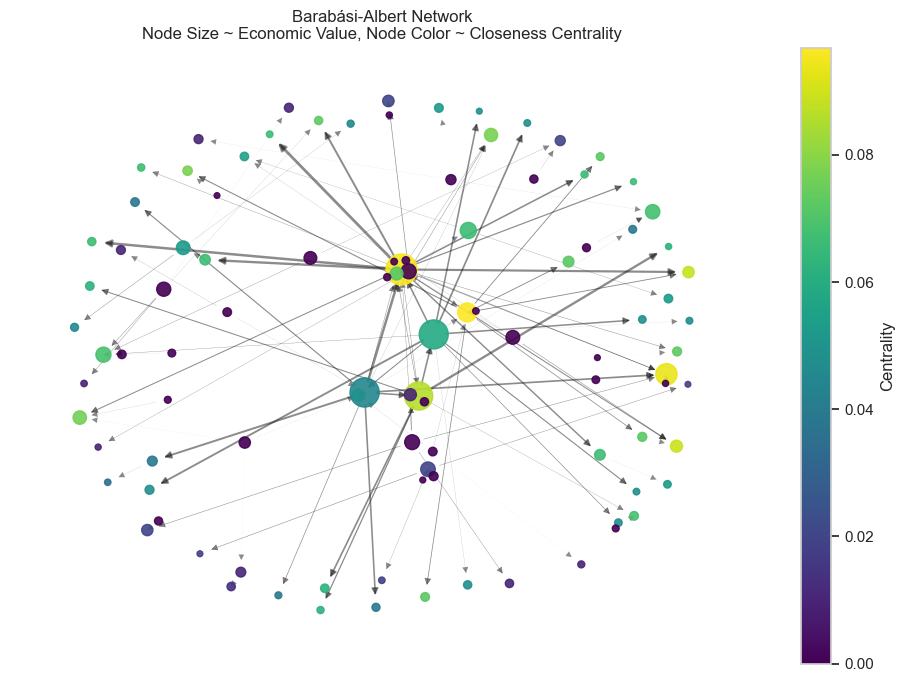

In [64]:
# Choose a network
name = 'Barabási-Albert'
G = graphs[name]

# Prepare data
centrality, E = prepare_visualization_data(G)

centrality_measure = 'closeness'  

# Get node sizes and colors
node_sizes, node_colors = get_node_sizes_and_colors(G, centrality, E, centrality_measure)

# Positions for consistent layout
positions = nx.spring_layout(G, seed=42)

# Edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# Visualize
visualize_graph(
    G,
    positions,
    node_sizes,
    node_colors,
    title=f"{name} Network\nNode Size ~ Economic Value, Node Color ~ {centrality_measure.capitalize()} Centrality",
    edge_weights=edge_weights
)


In [65]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [66]:
def plot_network_at_time(G, distress_levels, positions, title):
    # Node colors based on distress levels
    node_colors = [distress_levels[node] for node in G.nodes()]
    
    # Draw the network
    plt.figure(figsize=(8, 6))
    nodes = nx.draw_networkx_nodes(
        G,
        positions,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        node_size=100,
        vmin=0,  # Minimum distress level
        vmax=1   # Maximum distress level
    )
    edges = nx.draw_networkx_edges(G, positions, alpha=0.5)
    plt.colorbar(nodes, label='Distress Level')
    plt.title(title)
    plt.axis('off')
    plt.show()


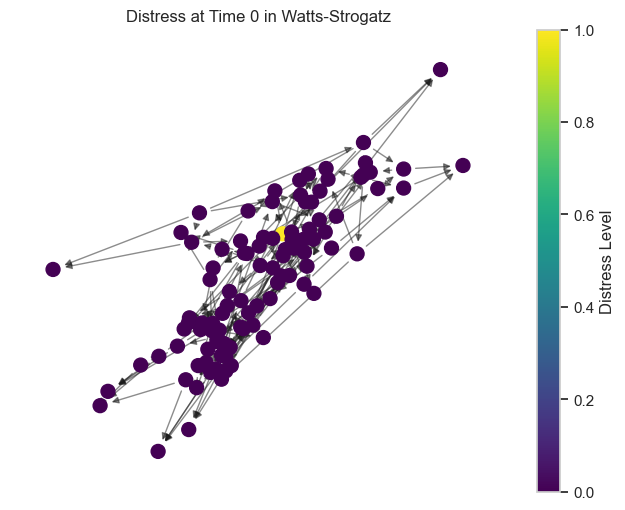

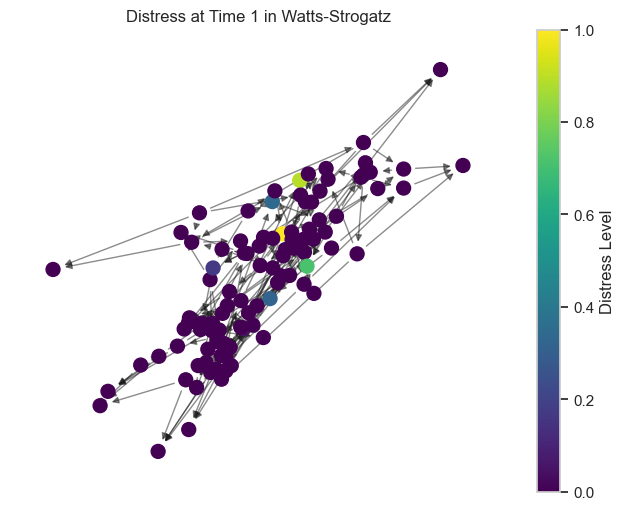

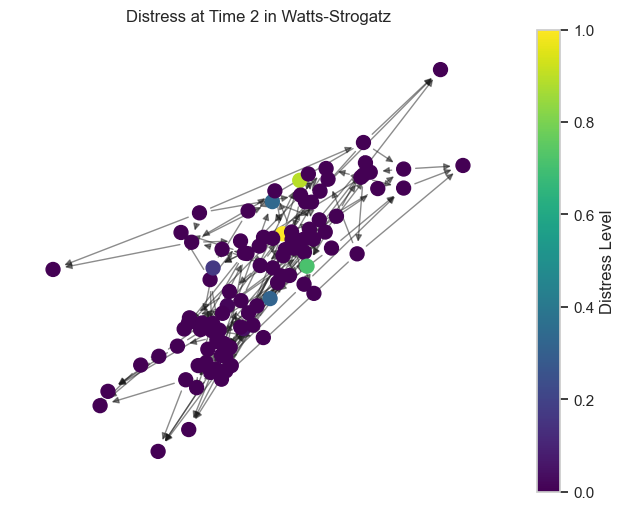

In [67]:
# For a specific network and time step
name = 'Watts-Strogatz'
G = graphs[name]
h_over_time = results[name]['h_over_time']
positions = nx.spring_layout(G, seed=42)  # Precompute positions for consistency

# Plot the network at time step t
t = 0  # Time step index
distress_levels_t = h_over_time[t]

for t in range(len(h_over_time)):
    distress_levels_t = h_over_time[t]
    plot_network_at_time(G, distress_levels_t, positions, f'Distress at Time {t} in {name}')



In [68]:
def animate_shock_propagation(G, h_over_time, positions, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    
    # Prepare the color map
    cmap = plt.cm.viridis
    vmin = 0
    vmax = 1

    def update(t):
        ax.clear()
        ax.set_title(f'{title} at Time {t}')
        ax.axis('off')
        distress_levels = h_over_time[t]
        node_colors = [distress_levels[node] for node in G.nodes()]
        nodes = nx.draw_networkx_nodes(
            G,
            positions,
            node_color=node_colors,
            cmap=cmap,
            node_size=100,
            ax=ax,
            vmin=vmin,
            vmax=vmax
        )
        nx.draw_networkx_edges(G, positions, alpha=0.5, ax=ax)
        return nodes,
    
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(h_over_time),
        blit=False,
        repeat=False
    )
    plt.close()  # Prevents static image display
    return ani


In [69]:
graphs

{'Erdős–Rényi': <networkx.classes.digraph.DiGraph at 0x177e3fdf0>,
 'Watts-Strogatz': <networkx.classes.digraph.DiGraph at 0x16bdc4d30>,
 'Barabási-Albert': <networkx.classes.digraph.DiGraph at 0x16b86f820>}

In [70]:
from IPython.display import HTML

name = 'Watts-Strogatz'
G = graphs[name]
h_over_time = results[name]['h_over_time']
positions = nx.spring_layout(G, seed=42)

ani = animate_shock_propagation(G, h_over_time, positions, f'Shock Propagation in {name}')
HTML(ani.to_jshtml())
